In [37]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc
import pandas as pd

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\genotype_comparison")
save_path.mkdir(parents=True, exist_ok=True)

include = [1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
condition = [0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2]
earliest_frames = [25, 43, 63, 80, 75, 150, 23, 36, 17, 70, 3]

dnt.set_plot_style()

spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]

print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_bcd_20251105a_spots', 'lightsheet_bcd_20251106_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:00,  2.03it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:02,  1.67it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:04,  1.55it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:05,  1.19it/s]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 9it [00:07,  1.10s/it]

[  0 150 180 240 300 400] 0 397


reading spots dfs: 10it [00:09,  1.12s/it]

[  0  60 100 150 220 340] 0 324


reading spots dfs: 11it [00:10,  1.13s/it]

[  0  25  60 120 200 280] 0 280


reading spots dfs: 12it [00:11,  1.20s/it]

[  0  50  80 120 200 280] 0 280


reading spots dfs: 13it [00:13,  1.28s/it]

[  0  25  55 100 180 280] 0 241


reading spots dfs: 14it [00:14,  1.26s/it]

[  0  55  90 140 200 350] 0 311


reading spots dfs: 16it [00:16,  1.02s/it]


Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'status', 'source', 'is_parent', 'is_child',
       'pseudotime', 'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP',
       'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


In [14]:
import dnt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

all_lengths = defaultdict(list)

for k in tqdm(range(len(spots_dfs))):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    ap_vals = np.linspace(0.05, 0.95, 6)


    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)


    for cycle in [11, 12, 13]:
        df_subset = df[df["cycle"] == cycle]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

        num_nuclei = df_subset.groupby("AP_bin").size()

        t = df_subset.groupby(["tracklet_id"])

        if condition[k] == 1:
            df_subset["time_since_nc11"] = df_subset["time_since_nc11"] / 60

        start_times = t["time_since_nc11"].min().values
        end_times = t["time_since_nc11"].max().values
        lengths = end_times - start_times

        AP_bins = t["AP_bin"].last().values

        for bin_idx in range(len(df_subset["AP_bin"].unique())):
            in_bin = AP_bins == (bin_idx + 1)

            all_lengths["cycle"].append(cycle)
            all_lengths["embryo"].append(k)
            all_lengths["AP_bin"].append(bin_idx + 1)
            all_lengths["condition"].append(condition[k])
            all_lengths["start_time"].append(start_times[in_bin].mean())
            all_lengths["end_time"].append(end_times[in_bin].mean())
            all_lengths["length"].append(lengths[in_bin].mean())
            all_lengths["relative_length"].append(lengths[in_bin].mean() - lengths.mean())
            all_lengths["n_nuclei"].append(np.sum(in_bin))

all_lengths = pd.DataFrame(all_lengths)


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


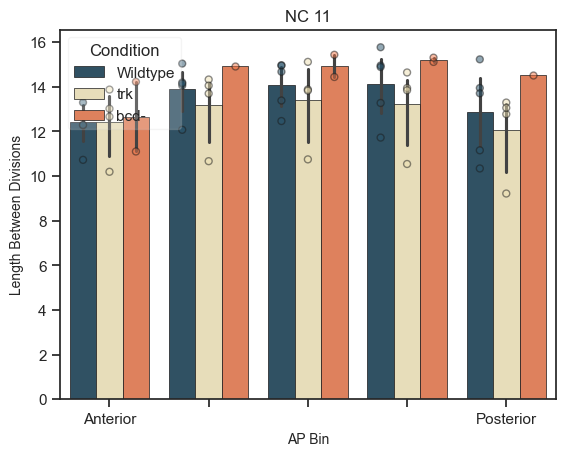

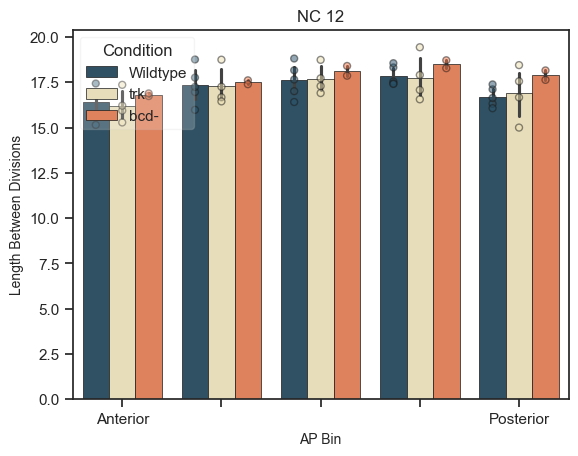

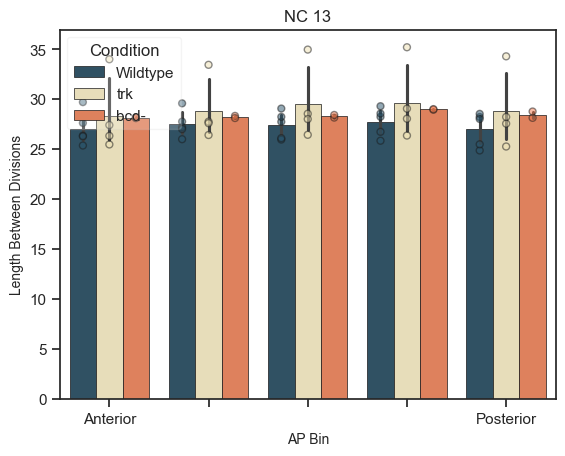

In [16]:
condition_pal = ["#28536B", "#EEE1B3", "#F37748"]
bin_labels = ["Anterior", " ", "  ", "   ", "Posterior"]

for cycle in [11, 12, 13]:
    subset_df = all_lengths[all_lengths["cycle"] == cycle]
    subset_df = subset_df[subset_df["condition"].isin([0, 1, 2])].copy()
    # subset_df = subset_df[subset_df["embryo"] != 6].copy()
    subset_df = subset_df[subset_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

    subset_df["condition"] = subset_df["condition"].replace({0: "Wildtype", 1: "bcd-", 2: "trk"})
    subset_df["AP_bin"] = subset_df["AP_bin"].replace({bin_idx + 1: label for bin_idx, label in enumerate(bin_labels)})

    hue_order = ["Wildtype", "trk", "bcd-"]

    sns.barplot(data=subset_df, x="AP_bin", y="length", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k', hue_order=hue_order)
    sns.stripplot(data=subset_df, x="AP_bin", y="length", hue="condition", dodge=True, palette=condition_pal, alpha=0.5, legend=False, edgecolor="k", linewidth=1, jitter=False, hue_order=hue_order)

    plt.legend(loc="upper left", title="Condition")

    plt.xlabel("AP Bin")
    plt.ylabel("Length Between Divisions")
    plt.title(f"NC {cycle}")

    plt.savefig(save_path / f"nc{cycle}_interphase_length_ap_condition.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
condition_pal = ["#28536B", "#F37748", "#EEE1B3"]
earliest_frames = [25, 43, 63, 80, 80, 150, 23, 36, 17, 70, 3]


for i, df in enumerate(spots_dfs):
    print("="*25)
    print(f"embryo {i}")
    df = df[df["frame"] >= earliest_frames[i]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    plot_timepoints = True

    sns.lineplot(df, x="time_since_nc11", y=df["dtot"]*60, errorbar=None, color="k", label="Speed", linewidth=3.0, legend=plot_timepoints)

    frame_cycle = df.groupby("frame")["cycle"].mean()
    for cycle in cycles[1:]:
        cycle_start = np.argmax(frame_cycle.values >= cycle - 0.5)
        plt.axvline(df["time_since_nc11"].unique()[cycle_start], color="k", linestyle="--", linewidth=1.0)

    if plot_timepoints:
        for cycle, line in zip(cycles, times):
            plt.axvline(line, color=dnt.palettes.nc[cycle], label=f"NC{cycle}", linewidth=3.0)
            plt.legend()

    plt.xlabel("Time since nc11 start (mins)")
    plt.ylabel("Avg nucleus speed (um/min)")

    plt.show()

    df_subset = df[df["frame"].isin(min_mvmt_frames)]
    print(np.sum(df_subset["cycle"] == 13))
    print(np.sum(df_subset["cycle"] == 10))
    t = df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()

    """
    Plot nuclear movement along AP axis
    """
    cycle = 13
    plt.scatter(t.loc[:, ("AP", 10)], t.loc[:, ("AP", cycle)] - t.loc[:, ("AP", 10)], color=condition_pal[condition[i]])

    plt.ylabel("AP movement by nc13")
    plt.xlabel("AP position at cycle 10")
    plt.axhline(0, color="k", linestyle="--", linewidth=5)
    plt.title("Nuclear movement along AP axis")

    plt.savefig(save_path / f"{stems[i]}_ap_dispacement_nc13")
    plt.show()

In [12]:
print(stems)

['lightsheet_20250131_spots', 'lightsheet_20250625_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_bcd_20251105a_spots', 'lightsheet_bcd_20251106_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots']


133 381 [ 69  71  74  83  86  91  93  94 104 105 113 114 120 121 124 130 131 135
 136 140 142 143 146 147 148 149 150 151 155 157 158 159 160 161 162 167
 168 171 172 177 178 181 182 186 187 189 191 195 197 198 200 202 204 207
 209 211 212 214 215 216 217 221 222 223 224 226 227 228 229 230 231 232
 234 235 236 237 238 239 240 242 243 244 245 246 252 258 259 260 262 263
 264 265 271 274 275 278 282 284 285 286 288 289 295 301 305 308 327 342
 347 348 352 448 452 461 463 464]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


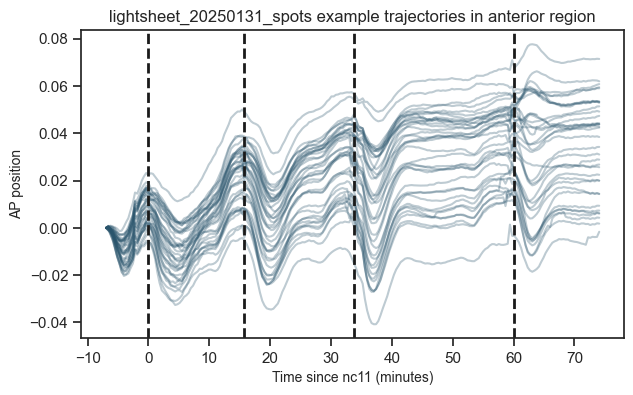

331 556 [  68   70   71   74   75   76   77   78   79   84   87   90   91   92
   93   94   95   97   98  100  101  102  103  104  105  106  107  108
  109  111  112  113  114  115  116  117  118  119  120  121  122  123
  124  125  126  128  130  131  132  133  134  137  139  140  141  142
  144  145  146  147  148  149  152  153  154  157  159  163  166  168
  169  171  172  175  176  178  180  199  203  210  211  249  273  274
  275  277  278  282  283  285  291  292  296  297  301  302  304  305
  310  311  315  316  317  318  320  321  335  336  339  348  353  354
  362  584  732 1001 1294 1299 1300 1301 2369 2370 2375 2389 2392 2394
 2412 2413 2424 2437 2446 2450 2451 2453 2458 2461]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


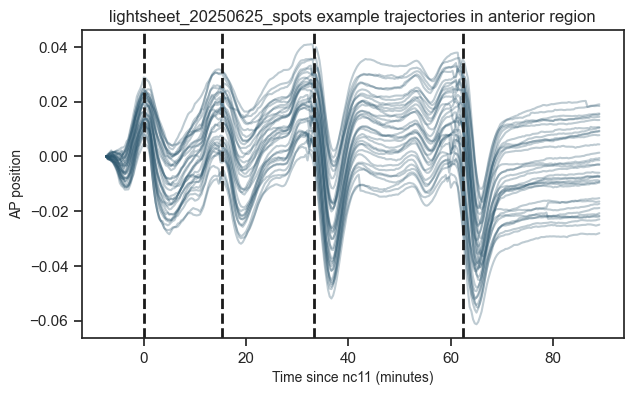

139 407 [  50   75   78   86   94  114  119  120  121  123  124  128  129  139
  142  145  146  148  151  154  155  157  162  168  170  173  174  176
  182  183  184  189  191  192  194  195  196  200  201  202  204  205
  206  207  209  210  212  215  217  218  221  223  224  225  226  227
  228  229  231  232  233  235  236  237  239  240  241  242  243  245
  247  249  251  252  254  257  258  263  265  267  268  269  271  274
  278  281  283  286  288  294  297  300  303  305  308  312  313  314
  316  323  326  330  335  337  339  352  353  381  386  575 1542]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


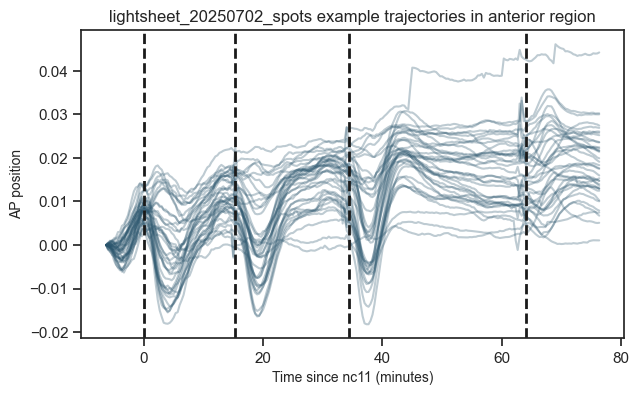

317 463 [  27   58   64   65   68   70   72   74   78   80   84   90   93   94
   96  100  103  104  105  106  110  111  112  114  115  116  117  118
  119  121  122  124  125  126  129  131  132  133  135  136  137  141
  143  144  147  148  149  151  154  155  156  157  158  162  167  169
  171  174  176  182  209  211  214  240  241  247  248  269  272  277
  279  281  282  283  284  285  286  287  289  290  291  293  294  298
  303  305  306  311  315  319  321  322  325  326  330  331  333  336
  340  343  348  356  357  358  360  362  367  368  370  373  408  410
  412  431  435  631  795 1487 3054 3066 3068 3069 3074 3077 3095]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (39) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


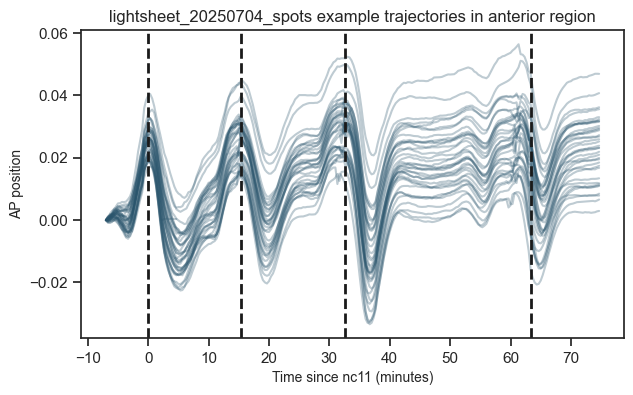

163 427 [ 12  14  19  20  22  28  30  33  34  35  40  46  47  66  69  76  77  78
  85  89  90  92  93  94  98 100 103 106 109 117 118 119 124 126 128 131
 136 137 138 142 145 153 154 155 157 159 160 163 166 169 172 174 178 179
 185 186 189 191 192 194 195 199 203 204 209 215 216 218 219 234 239 241
 249 251 255 256 261 265 268 283 284 288 289 292 297 300 304 314 315 327
 334 340 342 343 345 349 351 355 382 383 384 387 416 418 419 420 439]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


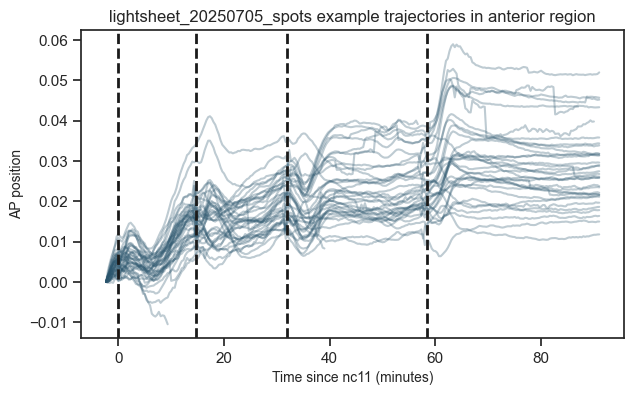

212 475 [ 15436  15859  16004  16007  16011  16098  16102  16106  16204  16209
  16210  16222  16230  16232  16311  16317  16320  16325  16328  16329
  16332  16334  16448  16452  16470  16472  16476  16477  16478  16482
  16559  16562  16564  16577  16578  16663  16672  16676  16677  16688
  16692  16693  16702  16800  16801  16809  16813  16818  16949  16958
  16975  17136  18462  20953  20956  20961  20963  20968  20969  20975
  20983  20984  20990  20998  20999  21000  21001  21002  21007  21010
  21018 280990 281096 281101 281104 281180 281181 281184 281190 281263
 281270 281274 281356 281360 281361 281367 281369 281372 281379 281443
 281446 281451 281466 281470 281550 281552 281553 281555 281559 281560
 281561 281562 281665 281670 281679 281685 281791 281795 281806 281811
 281815 281835 281923 281927 281932 281933 281948 282070 282079 282089
 282211 282220 282824 283909 285146 286090 286097 286101 286104 286105
 286109 286110 286117 286122 286126 286127 286128 286132 286135 28614

C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


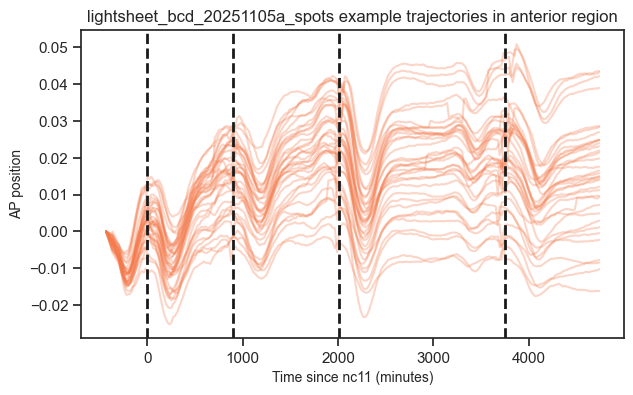

155 625 [5874851 5874862 5874863 5874864 5874865 5874867 5874878 5874879 5874882
 5874891 5874896 5874911 5874914 5874986 5875198 5875240 5875327 5875332
 5875352 5875353 5875357 5875362 5875366 5875370 5875373 5875374 5875405
 5875416 5875430 5875431 5875432 5875433 5875434 5875509 5875513 5875518
 5875519 5875520 5875522 5875524 5875525 5875526 5875527 5875529 5875530
 5875641 5875646 5875649 5875763 5875918 5875932 5877441 5881948 5881949
 5881952 5881953 6173691 6173752 6173800 6173835 6173839 6173876 6173878
 6173894 6173898 6173919 6173931 6173946 6173954 6173964 6174142 6174146
 6174289 6174451 6174487 6174488 6174489 6174493 6174496 6174529 6174533
 6174536 6174539 6174546 6174547 6174548 6174550 6174551 6174552 6174553
 6174559 6174561 6174563 6174607 6174608 6174609 6174610 6174612 6174613
 6174615 6174616 6174617 6174618 6174619 6174621 6174622 6174623 6174625
 6174627 6174628 6174629 6174630 6174635 6174638 6174654 6174737 6174738
 6174741 6174742 6174743 6174745 6174748 61

C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


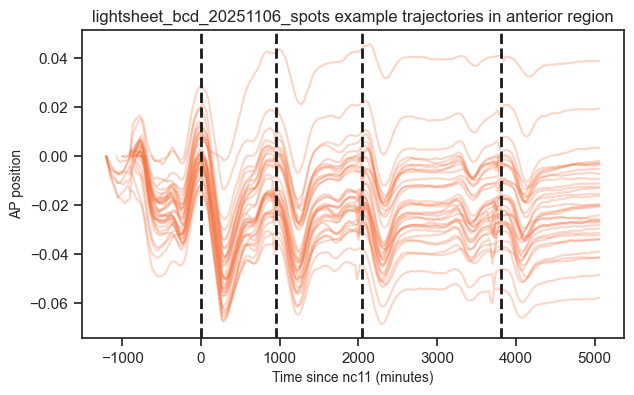

144 438 [  73   74   80   81   82   83   84   85   86   87   88   90   92   93
   96   97   98  100  101  103  104  107  110  114  116  120  123  124
  126  127  136  137  139  141  142  143  144  153  155  156  157  158
  162  163  165  166  167  171  173  174  176  177  178  181  182  184
  190  193  195  196  199  200  201  202  204  205  208  209  211  212
  216  218  219  220  222  223  224  225  227  228  232  233  234  238
  249  261  262  269  272  273  280  288  290  292  297  309  310  318
  319  328  350  351  362  397  418 1055 1057 1063]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


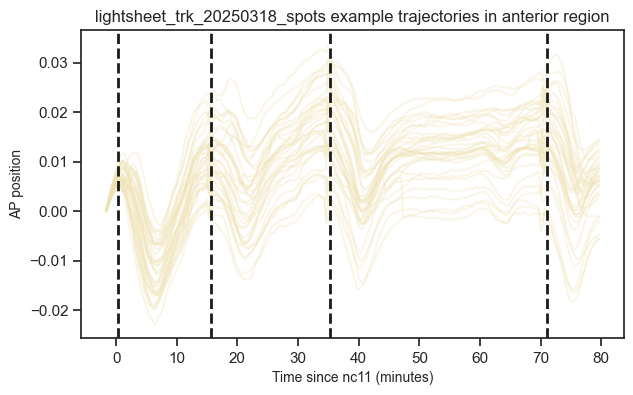

202 719 [  38   47   51   56   58   61   62   64   70   71   74   78   86   91
   92   95  105  112  113  123  124  127  131  136  137  140  143  144
  145  149  157  159  161  164  166  170  172  173  174  178  182  184
  185  188  190  191  192  199  201  203  206  207  209  210  211  212
  215  216  219  224  225  226  227  228  229  230  231  232  233  234
  235  236  237  238  239  240  244  245  246  248  249  250  253  254
  255  256  257  258  260  261  262  269  270  275  279  282  283  286
  287  293  294  298  304  307  309  311  316  321  322  325  361  364
  371  621  795  796  797  811  812  827  831 1353 1359 1360 1361 1362
 1363 1369 1370 1395 1413 1416 1417 1418 1426 1433 1446 1455 1456 1463
 1468 1486 1487 1489 1490 1505 1506 1534 1540 1542 1547 1548 1551 1554
 1555 1557]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


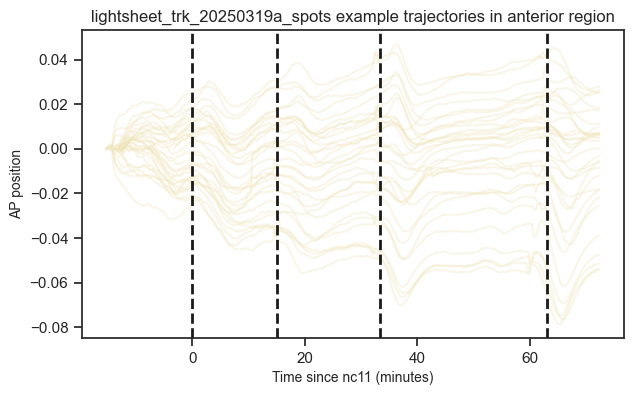

148 418 [  77   80   85   86  102  103  108  116  127  129  133  135  136  137
  139  146  148  149  150  154  155  156  157  169  173  176  178  180
  183  184  185  187  188  189  190  191  192  193  194  195  197  198
  200  201  203  204  205  206  209  210  211  213  214  215  216  218
  219  220  224  225  226  227  228  229  230  232  233  234  235  236
  237  238  239  240  242  246  252  259  267  268  272  273  280  286
  287  291  292  293  297  305  306  311  313  330  337  338  343  354
  355  358  369  371  372  373  374  375  378  379  386  552  759 1402
 1407 1409]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


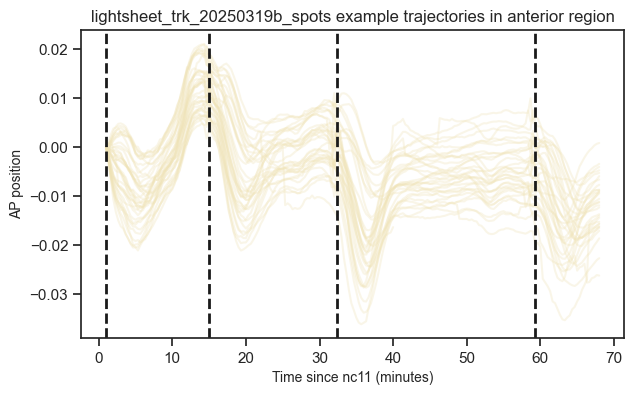

384 2136 [  65   89   90   96  107  108  114  115  116  117  121  128  129  130
  136  139  141  143  148  150  155  156  161  162  165  175  181  182
  185  189  191  197  198  199  200  202  203  204  205  207  208  211
  213  216  217  218  219  221  225  226  227  230  233  234  235  236
  237  238  239  241  242  244  245  247  248  249  250  252  254  255
  256  258  261  262  264  265  266  269  270  271  272  273  275  278
  282  284  286  287  288  289  290  291  292  293  294  295  297  298
  299  300  302  303  305  307  308  310  314  318  325  326  327  329
  338  346  350  351  353  377  454  457  459  463  469  513  564  590
  616  617  618  619  653  665  666  667  668  688  697  730  731  732
  733  747  751  752  753  754  755  756  757  758  790  791  792  802
  803  804  805  811  816  817  818  821  822  865  877  878  879  880
  881  882  883  884  886  889  890  891  892  893  894  896  910  958
  959  960  962  965  970  971  972  975  978  992 1016 1078 1079 10

C:\Users\Harrison\AppData\Local\Temp\ipykernel_15112\2833236231.py:32: UserWarning: 
The palette list has fewer values (1) than needed (46) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)


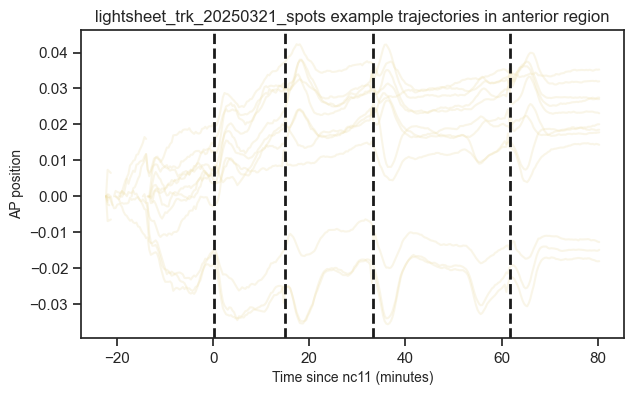

In [43]:
condition_pal = ["#28536B", "#F37748", "#EEE1B3"]
earliest_frames = [25, 43, 63, 80, 40, 150, 23, 36, 17, 40, 3]


for k, df in enumerate(spots_dfs):
    df = df.copy()
    df = df[df["frame"] >= earliest_frames[k]]

    t = df.groupby(["track_id", "frame"])[["x", "y", "z", "time_since_nc11", "AP", "theta", "distance", "cycle"]].mean().reset_index()

    t["AP_from_start"] = t["AP"] - t["track_id"].map(t.groupby("track_id")["AP"].first())

    region_track_ids = t[t["AP"].between(0.4, 0.6)]["track_id"].unique()
    early_track_ids = t.groupby("track_id")["time_since_nc11"].min() < 5
    early_track_ids = t["track_id"].unique()[early_track_ids]
    # low_distance = t.groupby("track_id")["distance"].mean() < 3.0
    # low_distance = t["track_id"].unique()[low_distance]

    all_good = np.intersect1d(region_track_ids, early_track_ids)

    print(len(region_track_ids), len(early_track_ids), all_good)

    np.random.seed(42)
    sampled_tracks = np.random.choice(all_good, 50)

    t = t[t["track_id"].isin(sampled_tracks)].copy()

    fig, axes = plt.subplots(figsize=(7, 4))

    this_color = condition_pal[condition[k]]

    sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette=[this_color], alpha=0.3, legend=False)

    for cycle in cycles[1:]:
        cycle_df = t[t["cycle"] == cycle]
        cycle_times = cycle_df.groupby("track_id")["time_since_nc11"].min()
        division_time = cycle_times.median()
        plt.axvline(division_time, color="k", linestyle="--", linewidth=2)

    plt.title(f"{stems[k]} example trajectories in anterior region")
    plt.ylabel("AP position")
    plt.xlabel("Time since nc11 (minutes)")
    # plt.ylim(-0.03, 0.13)
    plt.savefig(save_path / f"{stems[k]}_example_trajectories_middle_region_overview.png", dpi=300, bbox_inches="tight")
    plt.show()

In [2]:
import napari
viewer = napari.Viewer(ndisplay=3)
pal = dnt.palettes.nc
df = spots_dfs[4]
points = df[["frame", "z", "y", "x"]].values
colors = [pal[int(cycle)] for cycle in df["cycle"]]
viewer.add_points(points, size=5, face_color=colors, name="nuclei")
napari.run()


In [1]:
import dnt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

all_densities = defaultdict(list)

bin_sizes = []

counts = []
sas = []
lengths = []

for k in tqdm(range(len(spots_dfs))):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    points = df[df["frame"] == min_mvmt_frames[-1]][["x", "y", "z"]].values
    aps = df[df["frame"] == min_mvmt_frames[-1]]["AP"].values
    mesh = dnt.mesh_from_points(points)

    ap_vals = np.linspace(0.05, 0.95, 6)
    y_max = points[:, 1].max()
    y_min = points[:, 1].min()
    y_vals = y_min + ap_vals * (y_max - y_min)

    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)

    try:
        surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
    except Exception as e:
        mesh = dnt.smoothed_mesh_from_points(points)
        surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)

    # flip order of surface areas if y_max corresponds to AP=0
    if aps[np.argmax(points[:, 1])] < aps[np.argmin(points[:, 1])]:
        surface_areas = surface_areas[::-1]

    total_surface_area = surface_areas.sum()
    nc_14_nuclei = len(df[df["frame"] == min_mvmt_frames[-1]])

    counts.append(nc_14_nuclei)
    sas.append(total_surface_area)
    lengths.append(y_max - y_min)

    surface_areas = surface_areas[1:-1]

    rel_densities = []

    for frame, cycle in zip(min_mvmt_frames, cycles):
        df_subset = df[df["frame"] == frame]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])]

        num_nuclei = df_subset.groupby("AP_bin").size()

        actual_density = df_subset.groupby("AP_bin").size() / surface_areas
        rel_density = actual_density / (len(df_subset) / total_surface_area)

        rel_densities.append(rel_density.values)

        for bin_idx, (actual, rel) in enumerate(zip(actual_density.values, rel_density.values)):
            all_densities["cycle"].append(cycle)
            all_densities["embryo"].append(k)
            all_densities["AP_bin"].append(bin_idx + 1)
            all_densities["actual_density"].append(actual)
            all_densities["rel_density"].append(rel)
            all_densities["surface_area"].append(surface_areas[bin_idx])
            all_densities["condition"].append(condition[k])

    spots_dfs[k] = df
    bin_sizes.append(surface_areas)


NameError: name 'spots_dfs' is not defined

In [20]:
import napari
viewer = napari.Viewer(ndisplay=3)
pal = dnt.palettes.ap
df = spots_dfs[3]
points = df[["frame", "z", "y", "x"]].values
colors = [pal[int(b) % 5] for b in df["AP_bin"]]
viewer.add_points(points, size=5, face_color=colors, name="nuclei")
napari.run()

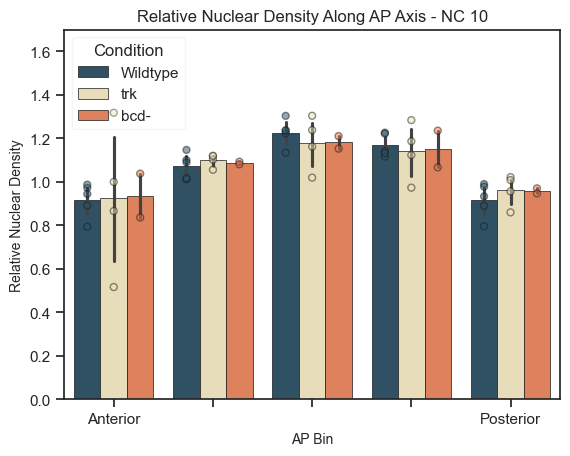

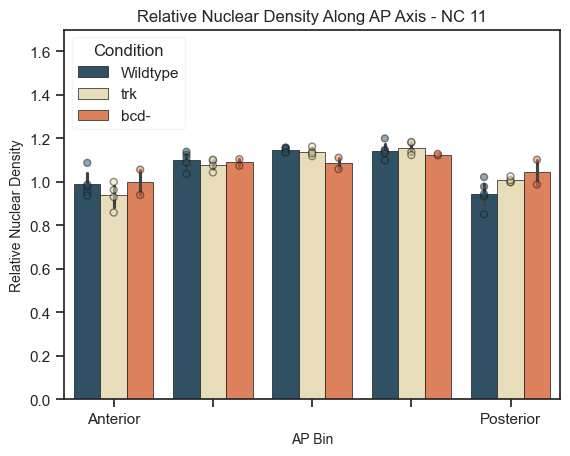

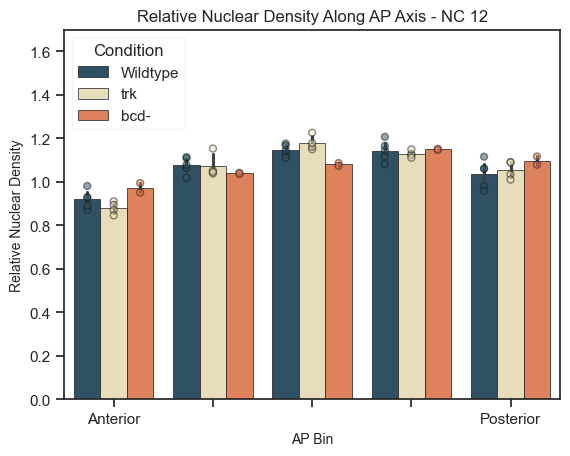

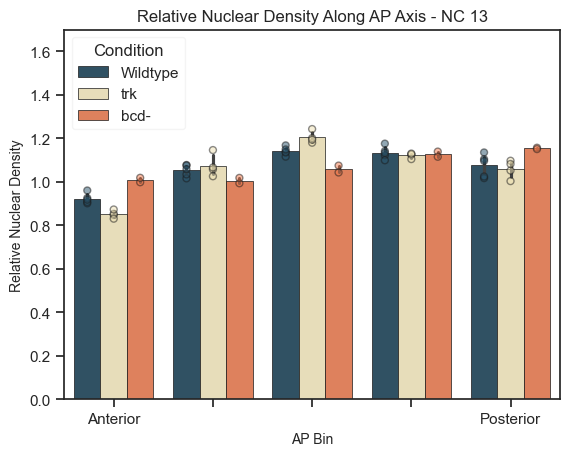

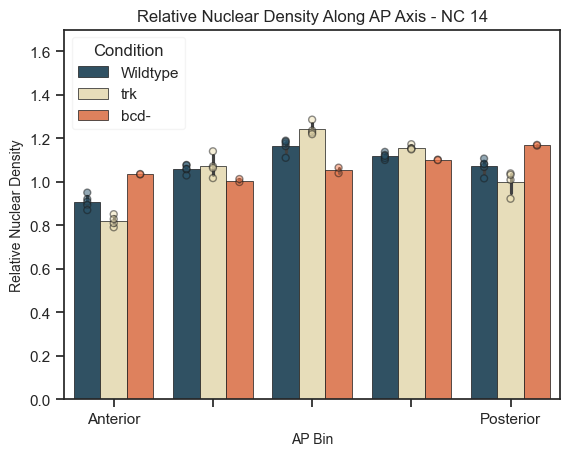

In [24]:
density_df = pd.DataFrame(all_densities)

condition_pal = ["#28536B", "#EEE1B3", "#F37748"]
bin_labels = ["Anterior", " ", "  ", "   ", "Posterior"]

for cycle in cycles:
    subset_df = density_df[density_df["cycle"] == cycle]
    subset_df = subset_df[subset_df["condition"].isin([0, 1, 2])].copy()
    # subset_df = subset_df[subset_df["embryo"] != 6].copy()
    subset_df = subset_df[subset_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

    subset_df["count"] = subset_df["actual_density"] * subset_df["surface_area"]
    subset_df["condition"] = subset_df["condition"].replace({0: "Wildtype", 1: "bcd-", 2: "trk"})
    subset_df["AP_bin"] = subset_df["AP_bin"].replace({bin_idx + 1: label for bin_idx, label in enumerate(bin_labels)})

    hue_order = ["Wildtype", "trk", "bcd-"]

    sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k', hue_order=hue_order)
    sns.stripplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", dodge=True, palette=condition_pal, alpha=0.5, legend=False, edgecolor="k", linewidth=1, jitter=False, hue_order=hue_order)

    plt.legend(loc="upper left", title="Condition")
    plt.ylim(0, 1.7)

    plt.xlabel("AP Bin")
    plt.ylabel("Relative Nuclear Density")
    plt.title(f"Relative Nuclear Density Along AP Axis - NC {cycle}")

    plt.savefig(save_path / f"nc{cycle}_relative_density_ap_condition.png", dpi=300, bbox_inches='tight')
    plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

 _Wildtype vs.  _trk: t-test independent samples, P_val:4.468e-01 t=-8.059e-01
  _Wildtype vs.   _trk: t-test independent samples, P_val:4.815e-01 t=7.433e-01
   _Wildtype vs.    _trk: t-test independent samples, P_val:6.956e-01 t=4.078e-01
Posterior_Wildtype vs. Posterior_trk: t-test independent samples, P_val:4.186e-01 t=-8.593e-01
Anterior_Wildtype vs. Anterior_trk: t-test independent samples, P_val:9.634e-01 t=-4.750e-02
 _Wildtype vs.  _bcd-: t-test independent samples, P_val:7.644e-01 t=-3.165e-01
  _Wildtype vs.   _bcd-: t-test independent samples, P_val:3.862e-01 t=9.491e-01
   _Wildtype vs.    _bcd-: t-test independent samples, P_val:7.924e-01 t=2.777e-01
Posterior_Wildtype vs. Posterior_bcd-: t-test independent samples, P_val:5.171e-01 t=-6.966e-01
Anterior_Wildtype vs. Anterior_bcd-: t-

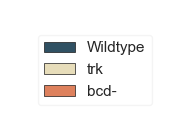

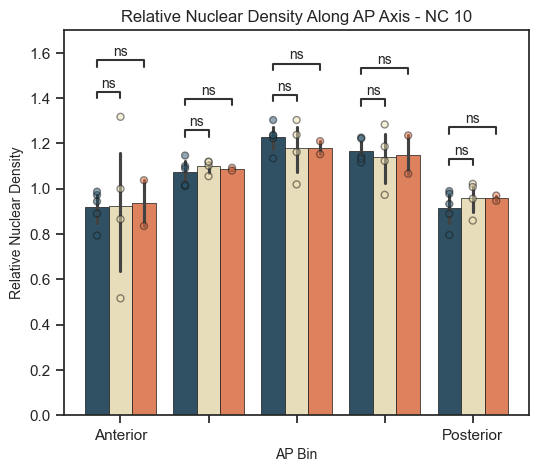

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

 _Wildtype vs.  _trk: t-test independent samples, P_val:4.162e-01 t=8.640e-01
  _Wildtype vs.   _trk: t-test independent samples, P_val:3.427e-01 t=1.018e+00
   _Wildtype vs.    _trk: t-test independent samples, P_val:6.104e-01 t=-5.332e-01
Posterior_Wildtype vs. Posterior_trk: t-test independent samples, P_val:9.828e-02 t=-1.906e+00
Anterior_Wildtype vs. Anterior_trk: t-test independent samples, P_val:2.421e-01 t=1.278e+00
 _Wildtype vs.  _bcd-: t-test independent samples, P_val:7.466e-01 t=3.415e-01
  _Wildtype vs.   _bcd-: t-test independent samples, P_val:1.104e-02 t=3.932e+00
   _Wildtype vs.    _bcd-: t-test independent samples, P_val:5.253e-01 t=6.823e-01
Posterior_Wildtype vs. Posterior_bcd-: t-test independent samples, P_val:1.383e-01 t=-1.762e+00
Anterior_Wildtype vs. Anterior_bcd-: t-te

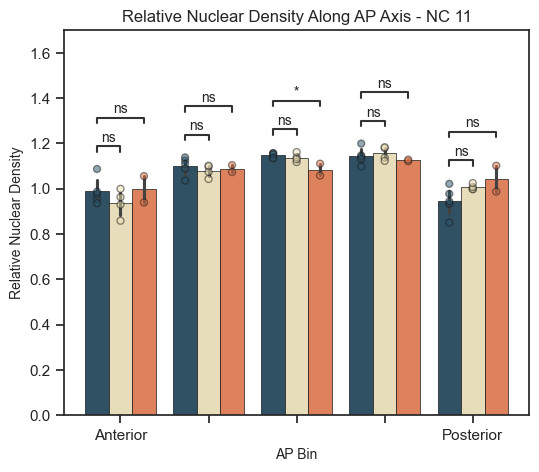

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

 _Wildtype vs.  _trk: t-test independent samples, P_val:8.833e-01 t=1.523e-01
  _Wildtype vs.   _trk: t-test independent samples, P_val:1.416e-01 t=-1.656e+00
   _Wildtype vs.    _trk: t-test independent samples, P_val:5.539e-01 t=6.215e-01
Posterior_Wildtype vs. Posterior_trk: t-test independent samples, P_val:5.939e-01 t=-5.586e-01
Anterior_Wildtype vs. Anterior_trk: t-test independent samples, P_val:1.549e-01 t=1.595e+00
 _Wildtype vs.  _bcd-: t-test independent samples, P_val:2.534e-01 t=1.290e+00
  _Wildtype vs.   _bcd-: t-test independent samples, P_val:2.516e-02 t=3.158e+00
   _Wildtype vs.    _bcd-: t-test independent samples, P_val:8.762e-01 t=-1.640e-01
Posterior_Wildtype vs. Posterior_bcd-: t-test independent samples, P_val:2.582e-01 t=-1.276e+00
Anterior_Wildtype vs. Anterior_bcd-: t-t

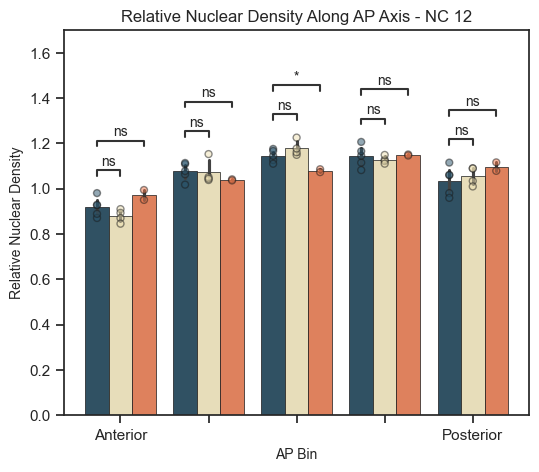

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

 _Wildtype vs.  _trk: t-test independent samples, P_val:4.407e-01 t=-8.173e-01
  _Wildtype vs.   _trk: t-test independent samples, P_val:4.439e-03 t=-4.124e+00
   _Wildtype vs.    _trk: t-test independent samples, P_val:4.180e-01 t=8.606e-01
Posterior_Wildtype vs. Posterior_trk: t-test independent samples, P_val:6.162e-01 t=5.244e-01
Anterior_Wildtype vs. Anterior_trk: t-test independent samples, P_val:1.389e-03 t=5.107e+00
 _Wildtype vs.  _bcd-: t-test independent samples, P_val:7.830e-02 t=2.208e+00
  _Wildtype vs.   _bcd-: t-test independent samples, P_val:4.207e-03 t=4.971e+00
   _Wildtype vs.    _bcd-: t-test independent samples, P_val:7.578e-01 t=3.258e-01
Posterior_Wildtype vs. Posterior_bcd-: t-test independent samples, P_val:1.008e-01 t=-2.009e+00
Anterior_Wildtype vs. Anterior_bcd-: t-te

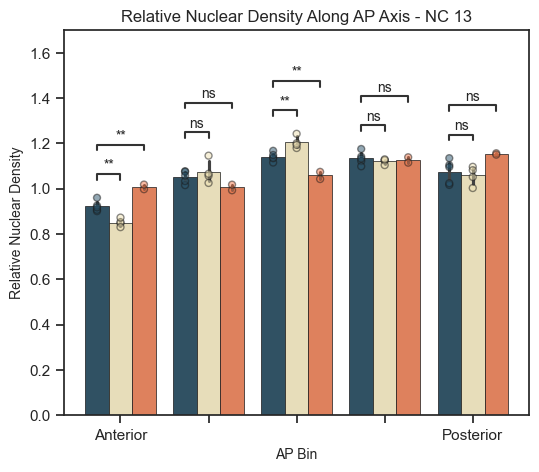

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

 _Wildtype vs.  _trk: t-test independent samples, P_val:6.086e-01 t=-5.360e-01
  _Wildtype vs.   _trk: t-test independent samples, P_val:8.131e-03 t=-3.654e+00
   _Wildtype vs.    _trk: t-test independent samples, P_val:2.594e-03 t=-4.564e+00
Posterior_Wildtype vs. Posterior_trk: t-test independent samples, P_val:4.649e-02 t=2.414e+00
Anterior_Wildtype vs. Anterior_trk: t-test independent samples, P_val:2.290e-03 t=4.669e+00
 _Wildtype vs.  _bcd-: t-test independent samples, P_val:1.578e-02 t=3.586e+00
  _Wildtype vs.   _bcd-: t-test independent samples, P_val:6.263e-03 t=4.523e+00
   _Wildtype vs.    _bcd-: t-test independent samples, P_val:1.676e-01 t=1.613e+00
Posterior_Wildtype vs. Posterior_bcd-: t-test independent samples, P_val:1.245e-02 t=-3.814e+00
Anterior_Wildtype vs. Anterior_bcd-: t-t

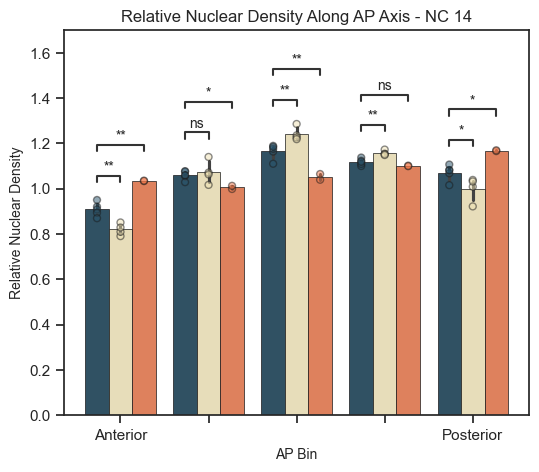

In [35]:
from statannotations.Annotator import Annotator

density_df = pd.DataFrame(all_densities)

condition_pal = ["#28536B", "#EEE1B3", "#F37748"]
bin_labels = ["Anterior", " ", "  ", "   ", "Posterior"]

for i, cycle in enumerate(cycles):

    fig, ax = plt.subplots(figsize=(6, 5))

    subset_df = density_df[density_df["cycle"] == cycle]
    subset_df = subset_df[subset_df["condition"].isin([0, 1, 2])].copy()
    # subset_df = subset_df[subset_df["embryo"] != 6].copy()
    subset_df = subset_df[subset_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

    subset_df["count"] = subset_df["actual_density"] * subset_df["surface_area"]
    subset_df["condition"] = subset_df["condition"].replace({0: "Wildtype", 1: "bcd-", 2: "trk"})
    subset_df["AP_bin"] = subset_df["AP_bin"].replace({bin_idx + 1: label for bin_idx, label in enumerate(bin_labels)})

    hue_order = ["Wildtype", "trk", "bcd-"]

    sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k', hue_order=hue_order)
    sns.stripplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", dodge=True, palette=condition_pal, alpha=0.5, legend=False, edgecolor="k", linewidth=1, jitter=False, hue_order=hue_order)

    box_pairs = []
    for position in bin_labels:
        box_pairs.append( ((position, "Wildtype"), (position, "trk")) )
        box_pairs.append( ((position, "Wildtype"), (position, "bcd-")) )

    annotator = Annotator(
        plt.gca(),
        box_pairs,
        data=subset_df,
        x="AP_bin",
        y="rel_density",
        hue="condition",
        hue_order=hue_order,
    )

    annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=True)
    annotator.apply_and_annotate()

    if i == 0:
        # save legend separately
        handles, labels = ax.get_legend_handles_labels()
        fig_legend = plt.figure(figsize=(2, 1.5))
        ax_legend = fig_legend.add_subplot(111)
        ax_legend.legend(handles, labels, loc='center', frameon=True)
        ax_legend.axis('off')
        fig_legend.tight_layout()
        fig_legend.savefig(save_path / "density_legend.png", dpi=300)

    ax.legend_.remove()

    plt.sca(ax)

    plt.ylim(0, 1.7)

    plt.xlabel("AP Bin")
    plt.ylabel("Relative Nuclear Density")
    plt.title(f"Relative Nuclear Density Along AP Axis - NC {cycle}")

    plt.savefig(save_path / f"nc{cycle}_relative_density_ap_condition_pvals.png", dpi=300, bbox_inches='tight')
    plt.show()

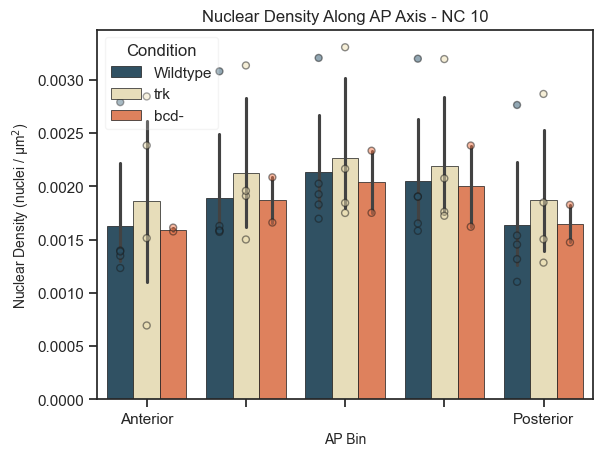

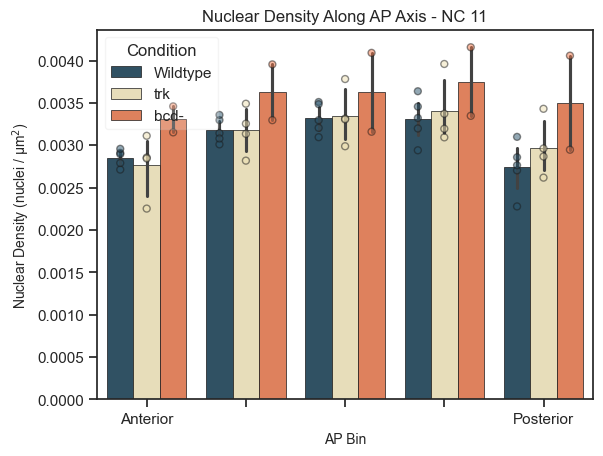

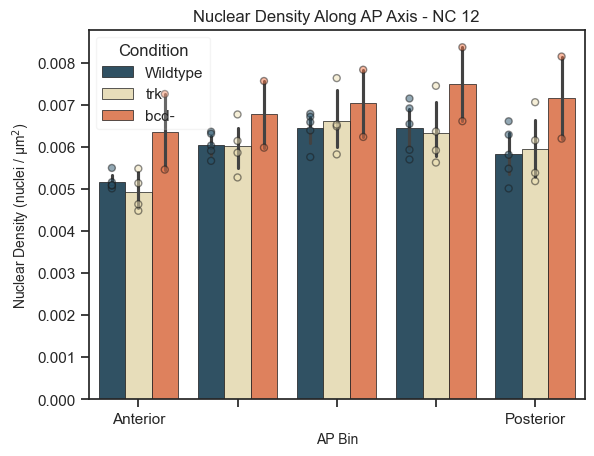

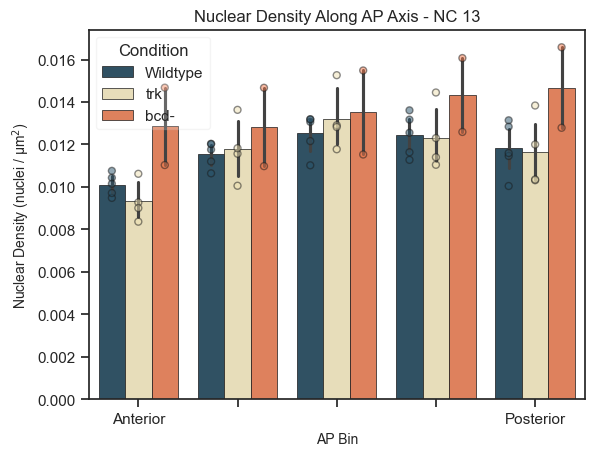

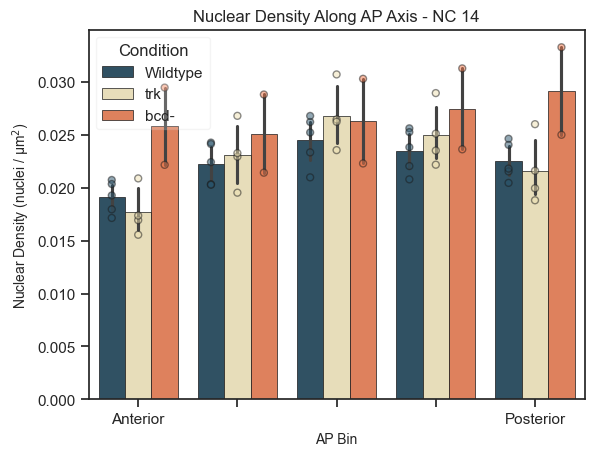

In [37]:
density_df = pd.DataFrame(all_densities)

condition_pal = ["#28536B", "#EEE1B3", "#F37748"]
bin_labels = ["Anterior", " ", "  ", "   ", "Posterior"]

for cycle in cycles:
    subset_df = density_df[density_df["cycle"] == cycle]
    subset_df = subset_df[subset_df["condition"].isin([0, 1, 2])].copy()
    # subset_df = subset_df[subset_df["embryo"] != 6].copy()
    subset_df = subset_df[subset_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

    subset_df["count"] = subset_df["actual_density"] * subset_df["surface_area"]
    subset_df["condition"] = subset_df["condition"].replace({0: "Wildtype", 1: "bcd-", 2: "trk"})
    subset_df["AP_bin"] = subset_df["AP_bin"].replace({bin_idx + 1: label for bin_idx, label in enumerate(bin_labels)})

    hue_order = ["Wildtype", "trk", "bcd-"]

    sns.barplot(data=subset_df, x="AP_bin", y="actual_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k', hue_order=hue_order)
    sns.stripplot(data=subset_df, x="AP_bin", y="actual_density", hue="condition", dodge=True, palette=condition_pal, alpha=0.5, legend=False, edgecolor="k", linewidth=1, jitter=False, hue_order=hue_order)

    plt.legend(loc="upper left", title="Condition")
    
    plt.xlabel("AP Bin")
    plt.ylabel("Nuclear Density (nuclei / μm$^2$)")
    plt.title(f"Nuclear Density Along AP Axis - NC {cycle}")

    plt.savefig(save_path / f"nc{cycle}_actual_density_ap_condition.png", dpi=300, bbox_inches='tight')
    plt.show()

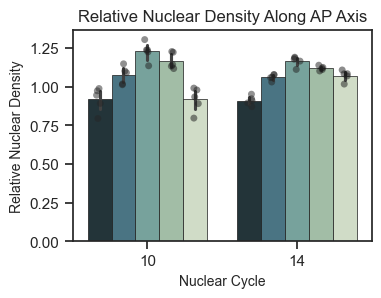

In [11]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df = density_df[density_df["condition"] == 0]
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 2: "Mid-Anterior", 3: "Middle", 4:"Mid-Posterio", 5: "Posterior"})

ap_pal = list(np.array(dnt.palettes.ap)[[0, 1, 2, 3, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.savefig(save_path / "nc_relative_density_ap_wt.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
timepoints_dfs = []

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    spots_dfs[i] = df

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    timepoints_dfs.append(dnt.generate_timepoint_df(df))

In [14]:
displacement_save_path = save_path.parent / "displacements"
displacement_save_path.mkdir(parents=True, exist_ok=True)

cycle_dfs = defaultdict(list)

for i, df in enumerate(spots_dfs):

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    df = df.copy()
    df["id"] = df.index
    df["first_id"] = df["track_id"].map(df.groupby("track_id")["id"].first())
    df["first_cycle"] = df["track_id"].map(df.groupby("track_id")["cycle"].first())
    df = df[df["first_cycle"] == 10].copy()

    displacements = {}
    for col in ["z", "y", "x", "AP"]:
        displacements[col] = df[col] - df["first_id"].map(df[col])

    df["dAP"] = displacements["AP"]
    df["prev_cycle"] = df["cycle"] - 1

    for j, frame in enumerate(min_mvmt_frames[1:]):
        cycle_df = df[df["frame"] == frame]
        t = cycle_df.groupby("track_id")[["AP", "dAP", "source"]].mean()

        sns.scatterplot(t, x="AP", y="dAP", color=dnt.palettes.nc[j+11], edgecolor="k")

        plt.ylabel("AP movement")
        plt.xlabel("AP position at cycle 10")

        plt.axhline(0, color="k", linestyle="--", linewidth=5)
        plt.title("Nuclear movement along AP axis")
        plt.savefig(displacement_save_path / f"{stems[i]}_nc{j+11}_movement_ap.png", dpi=300, bbox_inches='tight')

        plt.close()

        cycle_dfs[j+11].append(t)

In [ ]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df["bcd"] = density_df["embryo"] == density_df["embryo"].max()
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 2: "Mid-Anterior", 3: "Middle", 4:"Mid-Posterio", 5: "Posterior"})

ap_pal = list(np.array(dnt.palettes.ap)[[0, 1, 2, 3, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.show()

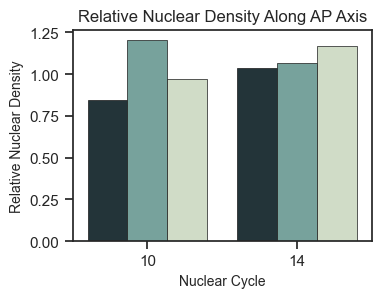

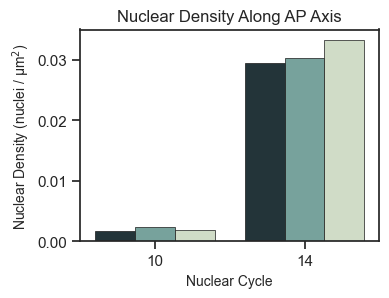

In [22]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 3, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})
ap_pal = list(np.array(dnt.palettes.ap)[[0, 2, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
# sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.savefig(save_path / "nc_relative_density_ap.png", dpi=300, bbox_inches='tight')
plt.show()

plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=density_df, x="cycle", y="actual_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k', legend=False)
# sns.stripplot(data=density_df, x="cycle", y="actual_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Nuclear Density (nuclei / μm$^2$)")
plt.title("Nuclear Density Along AP Axis")
# plt.legend(title="AP bin")
plt.savefig(save_path / "nc_raw_density_ap.png", dpi=300, bbox_inches='tight')
plt.show()

# density_df = pd.DataFrame(all_densities)
# sns.barplot(data=density_df, x="AP_bin", y="surface_area", hue="AP_bin", palette=dnt.palettes.ap)
#
# plt.show()

## Nuclear fallout

0
4910
[5 6 1 3 4 7 2]


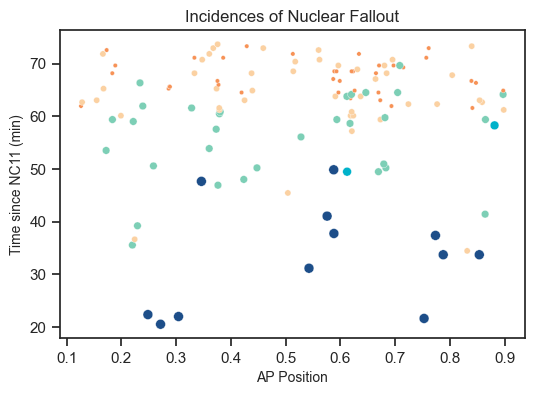

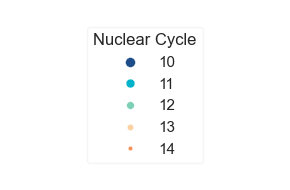

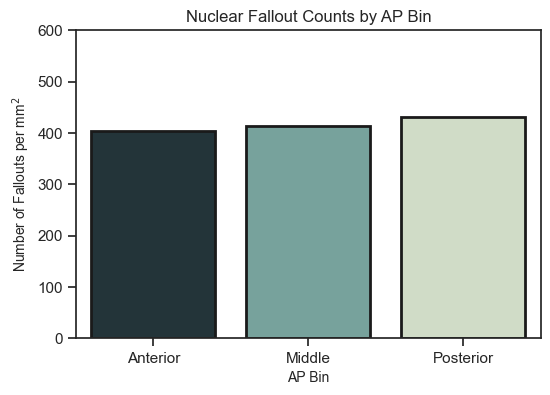

In [5]:
df = spots_dfs[0]
print((df["frame"] == 5).sum())
print((df["frame"] == 215).sum())
print(df["status"].unique())

terms = df[df["status"] == 2].copy()
terms = terms[terms["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)
plt.xlabel("AP Position")
plt.ylabel("Time since NC11 (min)")
plt.title("Incidences of Nuclear Fallout")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "fallout_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_fallout_ap_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
terms = terms[terms["AP_bin"].isin([1, 3, 5])].copy()
terms["AP_bin"] = terms["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})

bin_counts = terms.groupby("AP_bin")["frame"].count()
sns.barplot(x=bin_counts.index, y=10**6*np.array(bin_counts.values)/ np.array(bin_sizes[0])[[0, 2, 4]], hue=bin_counts.index, palette=ap_pal, lw=2, edgecolor='k')
plt.xlabel("AP Bin")
plt.ylabel("Number of Fallouts per mm$^2$")
plt.ylim(0, 600)
plt.title("Nuclear Fallout Counts by AP Bin")
plt.savefig(save_path / "nc_fallout_ap_bin_counts.png", dpi=300, bbox_inches='tight')
plt.show()

0
4910
[5 6 1 3 4 7 2]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_35128\1578880413.py:11: UserWarning: The sizes list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)


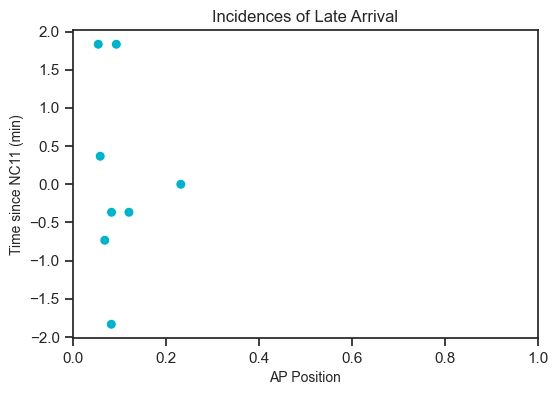

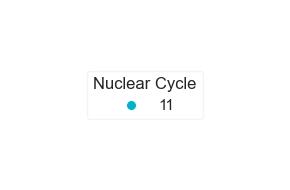

In [9]:
df = spots_dfs[0]
print((df["frame"] == 5).sum())
print((df["frame"] == 215).sum())
print(df["status"].unique())

terms = df[df["status"] == 5].copy()
terms = terms[terms["cycle"] > 10]
terms = terms[terms["time_since_nc11"] < 10]
terms = terms[terms["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)
plt.xlim(0, 1)
plt.xlabel("AP Position")
plt.ylabel("Time since NC11 (min)")
plt.title("Incidences of Late Arrival")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "arrival_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_arrival_ap_time.png", dpi=300, bbox_inches='tight')
plt.show()

# fig, ax = plt.subplots(figsize=(6, 4))
# terms = terms[terms["AP_bin"].isin([1, 3, 5])].copy()
# terms["AP_bin"] = terms["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})
#
# bin_counts = terms.groupby("AP_bin")["frame"].count()
# sns.barplot(x=bin_counts.index, y=10**6*np.array(bin_counts.values)/ np.array(bin_sizes[0])[[0, 2, 4]], hue=bin_counts.index, palette=ap_pal, lw=2, edgecolor='k')
# plt.xlabel("AP Bin")
# plt.ylabel("Number of Fallouts per mm$^2$")
# plt.ylim(0, 600)
# plt.title("Nuclear Fallout Counts by AP Bin")
# plt.savefig(save_path / "nc_fallout_ap_bin_counts.png", dpi=300, bbox_inches='tight')
# plt.show()

In [20]:
import dnt
import pandas as pd
from collections import defaultdict

all_densities = defaultdict(list)

bin_sizes = []

counts = []
sas = []
lengths = []

cycles_complete = [11, 12, 13]

for k in range(6):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    points = df[df["frame"] == min_mvmt_frames[-1]][["x", "y", "z"]].values
    mesh = dnt.mesh_from_points(points)

    ap_vals = np.linspace(0.05, 0.95, 6)
    y_max = points[:, 1].max()
    y_min = points[:, 1].min()
    y_vals = y_min + ap_vals * (y_max - y_min)

    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)

    surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
    total_surface_area = surface_areas.sum()

    nc_14_nuclei = len(df[df["frame"] == min_mvmt_frames[-1]])
    print(nc_14_nuclei, total_surface_area, nc_14_nuclei / total_surface_area)

    counts.append(nc_14_nuclei)
    sas.append(total_surface_area)
    lengths.append(y_max - y_min)

    surface_areas = surface_areas[1:-1]

    rel_densities = []

    for frame, cycle in zip(min_mvmt_frames[1:-1], cycles_complete):

        df_cycle_subset = df[df["cycle"] == cycle].copy()
        df_cycle_subset["time_in_cycle"] = df_cycle_subset.groupby("track_id")["time_since_nc11"].transform(lambda x: (x * 0) + (x.max() - x.min()))

        df_subset = df_cycle_subset[df_cycle_subset["frame"] == frame]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])]

        actual_density = df_subset.groupby("AP_bin").size() / surface_areas
        rel_density = actual_density / (len(df_subset) / total_surface_area)

        rel_densities.append(rel_density.values)

        for bin_idx, (actual, rel) in enumerate(zip(actual_density.values, rel_density.values)):
            all_densities["cycle"].append(cycle)
            all_densities["embryo"].append(k)
            all_densities["AP_bin"].append(bin_idx + 1)
            all_densities["actual_density"].append(actual)
            all_densities["rel_density"].append(rel)
            all_densities["surface_area"].append(surface_areas[bin_idx])
            all_densities["time_in_cycle"].append(df_subset[df_subset["AP_bin"] == bin_idx + 1]["time_in_cycle"].mean())


    spots_dfs[k] = df
    bin_sizes.append(surface_areas)

4862 242535.078125 0.020046584756264318
4772 225833.484375 0.021130613173713515
5605 230502.421875 0.024316447325831377
5457 240034.34375 0.022734246752971157
5847 241506.1875 0.02421055982261324
5179 243434.625 0.021274705683302038


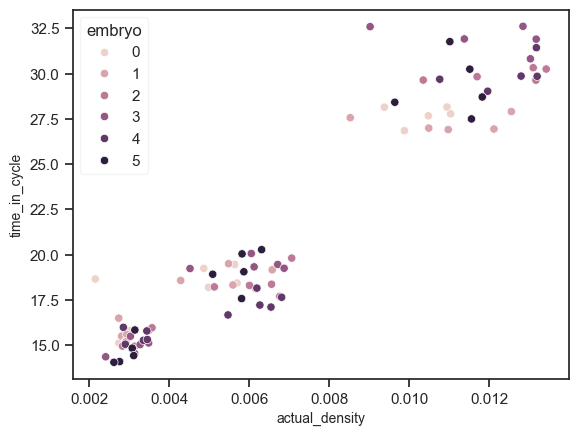

In [23]:
density_df = pd.DataFrame(all_densities)

sns.scatterplot(data=density_df, x="actual_density", y="time_in_cycle", hue="embryo")
plt.show()

# first neighbor CoV

In [13]:
import dnt
import pandas as pd
from collections import defaultdict
from scipy.spatial.distance import cdist
from tqdm import tqdm

all_distances = defaultdict(list)

for k in tqdm(range(6)):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    for frame, cycle in zip(min_mvmt_frames, cycles):
        df_subset = df[df["frame"] == frame]
        points = df_subset[["x", "y", "z"]].values
        pairwise_distances = cdist(points, points)
        np.fill_diagonal(pairwise_distances, 500)

        first_neighbor_distances = pairwise_distances.min(axis=1)

        all_distances["cycle"].append(int(cycle))
        all_distances["embryo"].append(k)
        all_distances["mean_distance"].append(first_neighbor_distances.mean())
        all_distances["std_distance"].append(first_neighbor_distances.std())
        all_distances["cov_distance"].append(first_neighbor_distances.std() / first_neighbor_distances.mean())

distance_df = pd.DataFrame(all_distances)


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


In [15]:
dnt.palettes.nc

{10: '#1d4e89', 11: '#00b2ca', 12: '#7dcfb6', 13: '#fbd1a2', 14: '#f79256'}

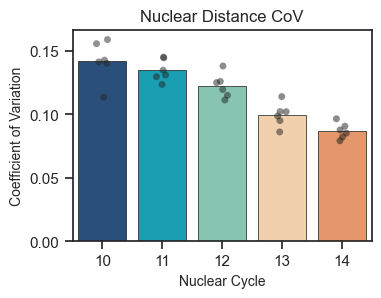

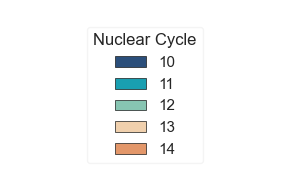

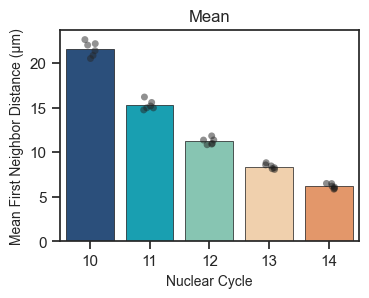

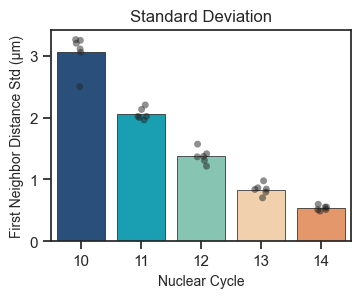

In [25]:
distance_df

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="cov_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None)
sns.stripplot(data=distance_df, x="cycle", y="cov_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Coefficient of Variation")
plt.title("Nuclear Distance CoV")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "nc_cov_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_cov_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="mean_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None, legend=False)
sns.stripplot(data=distance_df, x="cycle", y="mean_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Mean First Neighbor Distance (μm)")
plt.title("Mean")
plt.savefig(save_path / "nc_mean_distance_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="std_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None, legend=False)
sns.stripplot(data=distance_df, x="cycle", y="std_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("First Neighbor Distance Std (μm)")
plt.title("Standard Deviation")
plt.savefig(save_path / "nc_std_distance_time.png", dpi=300, bbox_inches='tight')
plt.show()

prev_bin   1.0    2.0    3.0    4.0   5.0   6.0
AP_bin                                         
0          3.0    0.0    0.0    0.0   0.0   0.0
1         85.0   11.0    0.0    0.0   0.0   0.0
2          0.0  131.0    8.0    0.0   0.0   0.0
3          0.0    0.0  150.0    3.0   0.0   0.0
4          0.0    0.0    8.0  134.0   1.0   0.0
5          0.0    0.0    0.0   11.0  84.0   1.0
6          0.0    0.0    0.0    0.0   4.0  20.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin                                                 
0         16.0    3.0    0.0    0.0    0.0    0.0   0.0
1          2.0  187.0    0.0    0.0    0.0    0.0   0.0
2          0.0   30.0  246.0    0.0    0.0    0.0   0.0
3          0.0    0.0   40.0  252.0    0.0    0.0   0.0
4          0.0    0.0    0.0   59.0  230.0    0.0   0.0
5          0.0    0.0    0.0    0.0   61.0  146.0   0.0
6          0.0    0.0    0.0    0.0    0.0   29.0  17.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin  

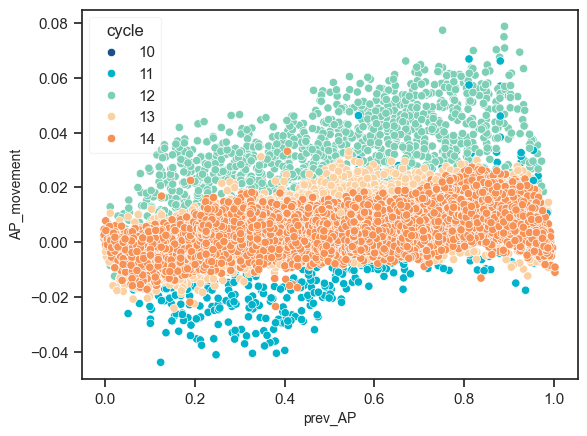

prev_bin       0.0    1.0    2.0     3.0    4.0    5.0    6.0
cycle AP_bin                                                 
11    0        0.0    3.0    0.0     0.0    0.0    0.0    0.0
      1        0.0   85.0   11.0     0.0    0.0    0.0    0.0
      2        0.0    0.0  131.0     8.0    0.0    0.0    0.0
      3        0.0    0.0    0.0   150.0    3.0    0.0    0.0
      4        0.0    0.0    0.0     8.0  134.0    1.0    0.0
      5        0.0    0.0    0.0     0.0   11.0   84.0    1.0
      6        0.0    0.0    0.0     0.0    0.0    4.0   20.0
12    0       16.0    3.0    0.0     0.0    0.0    0.0    0.0
      1        2.0  187.0    0.0     0.0    0.0    0.0    0.0
      2        0.0   30.0  246.0     0.0    0.0    0.0    0.0
      3        0.0    0.0   40.0   252.0    0.0    0.0    0.0
      4        0.0    0.0    0.0    59.0  230.0    0.0    0.0
      5        0.0    0.0    0.0     0.0   61.0  146.0    0.0
      6        0.0    0.0    0.0     0.0    0.0   29.0   17.0
13    0 

In [14]:
k = 0
df = spots_dfs[k].copy()
df = df[df["frame"] >= earliest_frames[k]]

timepoint_df = dnt.generate_timepoint_df(df)

timepoint_df["prev_AP"] = timepoint_df["prev_id"].map(timepoint_df["AP"])
timepoint_df["AP_movement"] = timepoint_df["AP"] - timepoint_df["prev_AP"]

timepoint_df["prev_bin"] = timepoint_df["prev_id"].map(timepoint_df["AP_bin"])
# timepoint_df["AP_bin_movement"] = timepoint_df["AP_bin"] - timepoint_df["prev_bin"]

for cycle in [11, 12, 13, 14]:
    subset = timepoint_df[timepoint_df["cycle"] == cycle]
    print(subset.groupby(["AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

sns.scatterplot(data=timepoint_df, x="prev_AP", y="AP_movement", hue="cycle", palette=dnt.palettes.nc)
plt.show()

print(timepoint_df.groupby(["cycle", "AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

print(len(timepoint_df))